In [1]:
# Usei como base esse tutorial:
# https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/keras/regression.ipynb#scrollTo=f-OHX4DiXd8x

In [2]:
# # # # Clear logs
# # # %rm -rf ./logs/

# # # Ativação do Tensorboard
# %conda activate pystock
# %load_ext tensorboard

# # # Reload Tensorboar
# %reload_ext tensorboard

In [3]:
# # # Reload Tensorboar
# %reload_ext tensorboa

In [4]:
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

# Sequential model

*Dense model 16*
*Dense model 16*
*Dense model 8*
*Dense model 4*
*Epoch 350*

_MSE: 1.31_
epoch: 350

Activation: softplus
Optimizer: Adam

15/15 - 0s - loss: 0.6325 - mae: 0.5830 - mse: 0.6325
Testing set Mean Abs Error:  0.58 ibova_0

In [5]:
TYPE_MODEL = "MLP"
REPETICAO = 0

<IPython.core.display.Javascript object>

In [6]:
import pathlib
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint
import keras_tuner as kt

<IPython.core.display.Javascript object>

# Lendo Dfs

In [7]:
# 80%
PATH_TREINO = "../Data/3_Gold/Treino_all_stocks.csv"
DF_TREINO = pd.read_csv(PATH_TREINO, sep=",")
train_dataset = DF_TREINO
train_dataset = train_dataset.drop(
    [
        "oil_5",
        "usd_5",
        "abev_5",
        "jbs_5",
        "petr_5",
        "vale_5",
    ],
    axis=1,
)
train_labels = train_dataset.pop("ibova_5")

# 20%
PATH_TESTE = "../Data/3_Gold/Teste_all_stocks.csv"
DF_TESTE = pd.read_csv(PATH_TESTE, sep=",")
test_dataset = DF_TESTE
test_dataset = test_dataset.drop(
    [
        "oil_5",
        "usd_5",
        "abev_5",
        "jbs_5",
        "petr_5",
        "vale_5",
    ],
    axis=1,
)
test_labels = test_dataset.pop("ibova_5")

"""Resultados"""
list_activation = []
list_best_epoch = []
list_best_model_path = []
list_learning_rate = []
list_hp_unit_1 = []
list_hp_unit_2 = []
list_hp_unit_3 = []
list_hp_unit_4 = []
list_kernel_size_1 = []
list_kernel_size_2 = []
list_n_filter_1 = []
list_n_filter_2 = []
list_val_mae = []
list_val_mse = []

<IPython.core.display.Javascript object>

# Inspecionando os dados

In [8]:
# sns.pairplot(train_dataset[['index','ibova_0','ibova_1','ibova_2','ibova_3','ibova_4','oil_0','oil_1','oil_2','oil_3','oil_4','usd_0','usd_1','usd_2','usd_3','usd_4']], diag_kind="kde")
# sns.pairplot(train_dataset[['index','ibova_0','oil_0','usd_0']], diag_kind="kde")
# sns.pairplot(train_dataset[['ibova_1','oil_1','usd_1']], diag_kind="kde")

# Fazer estatisticas dos conjuntos ibova e etec
# test_dataset.describe()
# train_stats = train_dataset.describe()
# train_stats

<IPython.core.display.Javascript object>

# Definindo o modelo

In [9]:
def model_builder(hp):
    hp_unit_1 = int(len(train_dataset.keys()))
    hp_unit_2 = hp.Int("unit_2", min_value=4, max_value=64, step=1)
    hp_unit_3 = hp.Int("unit_3", min_value=4, max_value=64, step=1)
    hp_unit_4 = hp.Int("unit_4", min_value=4, max_value=64, step=1)
    activationL = [
        "sigmoid",
        "softplus",
        "softsign",
        "tanh",
        "selu",
        "elu",
        "exponential",
        "relu",
    ]
    activation_choice = hp.Choice("activation", values=activationL)
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model = keras.Sequential(
        [
            layers.Dense(
                units=hp_unit_1,
                activation=activation_choice,
                input_shape=[len(train_dataset.keys())],
            ),
            layers.Dense(units=hp_unit_2, activation=activation_choice),
            layers.Dense(units=hp_unit_3, activation=activation_choice),
            layers.Dense(units=hp_unit_4, activation=activation_choice),
            layers.Dense(units=1, activation="linear"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse",
        metrics=["mae", "mse"],
    )

    return model


# rmse pra avaliação, nao para loss

<IPython.core.display.Javascript object>

In [10]:
# model.summary()

<IPython.core.display.Javascript object>

# Instanciando Tuner

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb#scrollTo=McO82AXOuxXh

In [11]:
tuner = kt.Hyperband(
    model_builder,
    objective="val_mse",
    max_epochs=50,
    factor=3,
    directory="logs",
    project_name="hyper_parameters",
)

tuner.get_best_hyperparameters(10)[0]

IndexError: list index out of range

<IPython.core.display.Javascript object>

# Selecionando a melhor epoca do modelo

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
save_time = datetime.datetime.strftime(datetime.datetime.now(), "%y_%m_%d_%Hh%Mm%S")

bst_model_path = f"Models/MLP/model_{save_time}.h5"
model_checkpoint = ModelCheckpoint(
    bst_model_path, save_best_only=True, monitor="val_mse", mode="min"
)

EPOCHS = 500

best_hps = tuner.get_best_hyperparameters(num_trials=100)[0]


model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_dataset,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=([model_checkpoint]),
)

# Select the best epoch,
val_mse_per_epoch = history.history["val_mse"]
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1

print("Best epoch: %d" % (best_epoch,))
print(f'val_mae: {min(history.history["val_mae"])}')
print(f'val_mse: {min(history.history["val_mse"])}')

Best epoch: 161
val_mae: 0.16078390181064606
val_mse: 0.04147687926888466


<IPython.core.display.Javascript object>

In [ ]:
try:
    value_activation = best_hps.get("activation")
except:
    value_activation = None

try:
    value_learning_rate = best_hps.get("learning_rate")
except:
    value_learning_rate = None
try:
    value_unit_1 = best_hps.get("unit_1")
except:
    value_unit_1 = None
try:
    value_unit_2 = best_hps.get("unit_2")
except:
    value_unit_2 = None
try:
    value_unit_3 = best_hps.get("unit_3")
except:
    value_unit_3 = None
try:
    value_unit_4 = best_hps.get("unit_4")
except:
    value_unit_4 = None
try:
    value_kernel_size_1 = best_hps.get("kernel_size_1")
except:
    value_kernel_size_1 = None
try:
    value_kernel_size_2 = best_hps.get("kernel_size_2")
except:
    value_kernel_size_2 = None
try:
    value_n_filter_1 = best_hps.get("n_filter_1")
except:
    value_n_filter_1 = None
try:
    value_n_filter_2 = best_hps.get("n_filter_2")
except:
    value_n_filter_2 = None


""""Repeticao MODEL.ipynb"""


def save_in_list(one_list, value=None):
    try:
        one_list.append(value)
        return one_list
    except:
        one_list.append(None)
        return one_list


list_best_epoch = save_in_list(list_best_epoch, best_epoch)
list_best_model_path = save_in_list(list_best_model_path, bst_model_path)
list_activation = save_in_list(list_activation, value_activation)
list_learning_rate = save_in_list(list_learning_rate, value_learning_rate)
list_hp_unit_1 = save_in_list(list_hp_unit_1, value_unit_1)
list_hp_unit_2 = save_in_list(list_hp_unit_2, value_unit_2)
list_hp_unit_3 = save_in_list(list_hp_unit_3, value_unit_3)
list_hp_unit_4 = save_in_list(list_hp_unit_4, value_unit_4)
list_kernel_size_1 = save_in_list(list_kernel_size_1, value_kernel_size_1)
list_kernel_size_2 = save_in_list(list_kernel_size_2, value_kernel_size_2)
list_n_filter_1 = save_in_list(list_n_filter_1, value_n_filter_1)
list_n_filter_2 = save_in_list(list_n_filter_2, value_n_filter_2)
list_val_mae = save_in_list(list_val_mae, min(history.history["val_mae"]))
list_val_mse = save_in_list(list_val_mse, min(history.history["val_mse"]))

<IPython.core.display.Javascript object>

In [ ]:
print(list_best_epoch)
print(list_best_model_path)
print(list_activation)
print(list_learning_rate)
print(list_hp_unit_1)
print(list_hp_unit_2)
print(list_hp_unit_3)
print(list_hp_unit_4)
print(list_kernel_size_1)
print(list_kernel_size_2)
print(list_n_filter_1)
print(list_n_filter_2)
print(list_val_mae)
print(list_val_mse)

[161]
['Models/MLP/model_22_10_09_21h48m39.h5']
['elu']
[0.01]
[50]
[19]
[12]
[21]
[None]
[None]
[None]
[None]
[0.16078390181064606]
[0.04147687926888466]


<IPython.core.display.Javascript object>

In [ ]:
result_columns = [
    "best_model_path",
    "best_epoch",
    "activation",
    "learning_rate",
    "hp_unit_1",
    "hp_unit_2",
    "hp_unit_3",
    "hp_unit_4",
    "kernel_size_1",
    "kernel_size_2",
    "n_filter_1",
    "n_filter_2",
    "val_mae",
    "val_mse",
]

data = {
    "best_epoch": [list_best_epoch],
    "best_model_path": [list_best_model_path],
    "activation": [list_activation],
    "learning_rate": [list_learning_rate],
    "hp_unit_1": [list_hp_unit_1],
    "hp_unit_2": [list_hp_unit_2],
    "hp_unit_3": [list_hp_unit_3],
    "hp_unit_4": [list_hp_unit_4],
    "kernel_size_1": [list_kernel_size_1],
    "kernel_size_2": [list_kernel_size_2],
    "n_filter_1": [list_n_filter_1],
    "n_filter_2": [list_n_filter_2],
    "val_mae": [list_val_mae],
    "val_mse": [list_val_mse],
}

pd.DataFrame(
    data,
    columns=result_columns,
)

,best_model_path,best_epoch,activation,learning_rate,hp_unit_1,hp_unit_2,hp_unit_3,hp_unit_4,kernel_size_1,kernel_size_2,n_filter_1,n_filter_2,val_mae,val_mse
0,[Models/MLP/model_22_10_09_21h48m39.h5],[161],[elu],[0.01],[50],[19],[12],[21],[None],[None],[None],[None],[0.16078390181064606],[0.04147687926888466]


<IPython.core.display.Javascript object>

In [ ]:
print(f'unit_1: {best_hps.get("unit_1")}')
print(f'unit_2: {best_hps.get("unit_2")}')
print(f'unit_3: {best_hps.get("unit_3")}')
print(f'unit_4: {best_hps.get("unit_4")}')
print(f'learning_rate: {best_hps.get("learning_rate")}')
print(f'activation: {best_hps.get("activation")}')

unit_1: 50
unit_2: 19
unit_3: 12
unit_4: 21
learning_rate: 0.01
activation: elu


<IPython.core.display.Javascript object>

In [ ]:
eval_result = model.evaluate(test_dataset, test_labels)
print("[test loss, test accuracy]:", eval_result)

15/15 [==============================] - 0s 2ms/step - loss: 4.3583 - mae: 0.4419 - mse: 4.3583
[test loss, test accuracy]: [4.358315467834473, 0.4418922960758209, 4.358315467834473]


<IPython.core.display.Javascript object>

# Avaliando o modelo

In [ ]:
# print(f'train_dataset: {train_dataset.columns()} \n')
# print(f'valid_dataset: {valid_dataset.columns()} \n')
# print(f'test_dataset: {test_dataset.columns()} \n')

<IPython.core.display.Javascript object>

In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,0.046412,0.164475,0.046412,0.049621,0.174507,0.049621,495
496,0.046276,0.164268,0.046276,0.055963,0.186377,0.055963,496
497,0.047024,0.164822,0.047024,0.048814,0.170782,0.048814,497
498,0.047177,0.165082,0.047177,0.050850,0.177800,0.050850,498
499,0.047393,0.166698,0.047393,0.059748,0.190226,0.059748,499


<IPython.core.display.Javascript object>

In [ ]:
print(f"Min MSE: {hist.mse.min()}")
print(f"Min Val_MSE: {hist.val_mse.min()}")

Min MSE: 0.044519923627376556
Min Val_MSE: 0.04147687926888466


<IPython.core.display.Javascript object>

In [ ]:
df_results = pd.DataFrame(
    columns=[
        "best_epoch",
        "val_mae",
        "val_mse",
        "n_filter_1",
        "n_filter_2",
        "kernel_size_1",
        "kernel_size_2",
        "learning_rate",
        "activation",
    ]
)

# for REPETICAO, value in enumerate((df_results)):
df_results.loc[REPETICAO, "bst_model_path"] = bst_model_path
df_results.loc[REPETICAO, "best_epoch"] = best_epoch
df_results.loc[REPETICAO, "val_mae"] = min(history.history["val_mae"])
df_results.loc[REPETICAO, "val_mse"] = min(history.history["val_mse"])
# df_results.loc[REPETICAO, "n_filter_1"] = best_hps.get("n_filter_1")
df_results.loc[REPETICAO, "n_filter_2"] = None
# df_results.loc[REPETICAO, "kernel_size_1"] = best_hps.get("kernel_size_1")
df_results.loc[REPETICAO, "kernel_size_2"] = None
df_results.loc[REPETICAO, "learning_rate"] = best_hps.get("learning_rate")
df_results.loc[REPETICAO, "activation"] = best_hps.get("activation")

df_results
# bst_model_path

,best_epoch,val_mae,val_mse,n_filter_1,n_filter_2,kernel_size_1,kernel_size_2,learning_rate,activation,bst_model_path
0,161,0.160784,0.041477,NaN,None,NaN,None,0.01,elu,Models/MLP/model_22_10_09_21h48m39.h5


<IPython.core.display.Javascript object>

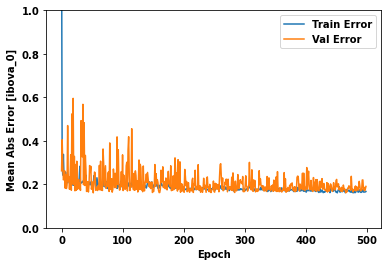

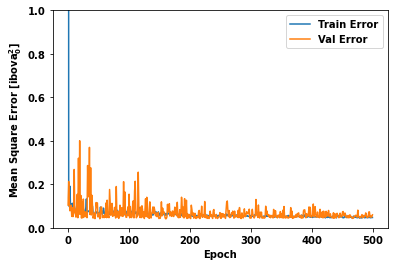

<IPython.core.display.Javascript object>

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [ibova_0]")
    plt.plot(hist["epoch"], hist["mae"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    plt.ylim([0, 1])
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$ibova_0^2$]")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    plt.ylim([0, 1])
    plt.legend()
    plt.show()


plot_history(history)

# Realizando as previsões

In [ ]:
# TODO: Ver se consigo extrair o mse daqui

test_predictions = model.predict(test_dataset).flatten()

15/15 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>

# Avaliando as previsões:

In [ ]:
def show_test_labels():
    # Imprimindo valores reais
    plt.plot(test_labels, color="r", label="ibova_REAL")
    plt.xlabel("Dates")
    plt.ylabel("Variation ROC")
    plt.title("ibova_REAL")
    plt.legend()


def show_model_predictions():
    # Imprimindo previsoes
    plt.plot(test_predictions, color="g", label="predictions_MODEL")
    plt.xlabel("Dates")
    plt.ylabel("Variation ROC")
    plt.title("predictions_MODEL")
    plt.legend()


def show_compare_graph():
    # Predictt X Real values
    plt.plot(test_labels, color="r", label="ibova_REAL")
    plt.plot(test_predictions, color="g", label="predictions_MODEL")
    plt.xlabel("Dates")
    plt.ylabel("Variation ROC")
    plt.title("Predict X Real values")
    plt.legend()
    plt.show()


def show_true_predict_values():
    plt.figure(figsize=(24, 4))
    plt.scatter(test_labels, test_predictions)
    plt.xlabel("True Values [ibova_0]")
    plt.ylabel("Predictions [ibova_0]")
    plt.axis("equal")
    plt.axis("square")
    plt.xlim([0, plt.xlim()[1]])
    plt.ylim([0, plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

<IPython.core.display.Javascript object>

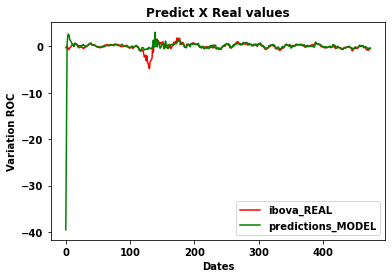

<IPython.core.display.Javascript object>

In [ ]:
show_compare_graph()

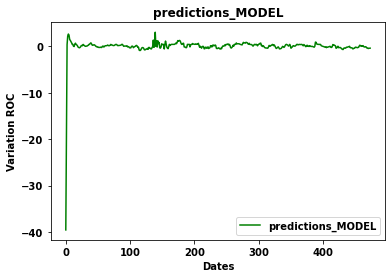

<IPython.core.display.Javascript object>

In [ ]:
show_model_predictions()

In [ ]:
model_name = f'mlp_unit_1({best_hps.get("unit_1")})unit_2({best_hps.get("unit_2")})unit_3({best_hps.get("unit_3")})unit_4({best_hps.get("unit_4")})_learning({best_hps.get("learning_rate")})_activation({best_hps.get("activation")})'
model_name
model.save(f"models/mlp/{model_name}date_{save_time}.h5")

<IPython.core.display.Javascript object>

In [ ]:
# Analisando Medias:

print(f"Massa de predição: {test_predictions.mean()}")
print(f"Massa inicial: {ibova_test.mean()}")
print(f"Diferenças das médias: {ibova_test.mean() - test_predictions.mean()}")

# Add o RM_MSE medio

Massa de predição: 0.024045521393418312


NameError: name 'ibova_test' is not defined

<IPython.core.display.Javascript object>

In [ ]:
save_time

'22_08_30_22h55m31'

<IPython.core.display.Javascript object>